In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap

from sklearn.model_selection import KFold, train_test_split
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import shap

import warnings 
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings('ignore')

In [2]:
SEED = 156

In [3]:
map_months={'Jan':'Jan', 'Feb':'Fev', 'Mar':'Mar', 'Apr':'Abr', 'May':'Maio', 'Jun':'Jun', 'Jul':'Jul', 'Aug':'Ago', 'Sep':'Set','Oct':'Out',
         'Nov':'Nov','Dec':'Dez'}
func_map_months = lambda mes: mes[:-3] + map_months[mes[-3:]]

In [4]:
def labs(ax, 
         title:str='', 
         subtitle:str='',
         xlabel:str='', 
         ylabel:str='',            
         spines_invisible:list=['top', 'right'],
         kwargs_grid:dict={'axis':'y', 'alpha':0.6}):
    '''
    Função que plota as informações adicionais dos gráficos, título, subtítulo, rótulos, labels, fontes
    
    Parâmetros:
    ----------
    ax : eixo a ser plotado o gráfico, se nenhum for passado será criado automaticamnete, tipo : matplotlib.axes
    title : título do gráfico, tipo : str, padrão : ''
    subtitle : subtítulo do gráfico, tipo : str, padrão : ''
    xlabel : rótulo do eixo x, tipo : str, padrão : ''
    ylabel : rótulo do eixo y, tipo : str, padrão : ''
    fonte : fonte dos dados para ser plotada no gráfico(embaixo), tipo : str, padrão : 'https://brasil.io/dataset/covid19/caso_full/'
    spines_invisible : nome dos eixos a serem ocultados, tipo : list, padrão : ['top', 'right']
    kwargs_grid : argumentos a serem passados pra função matplotlib.pyplot.grid, tipo : dict, padrão : {'axis':'y', 'alpha':0.6}
    '''
    
    plt.sca(ax)
    plt.title(title + '\n', fontsize=25, loc='left', color='black')
    plt.text(0,1.02, subtitle, color='gray', transform=ax.transAxes, fontsize=15)
    plt.xlabel(xlabel, color='#333333', fontsize=15)
    plt.ylabel(ylabel, color='#333333', fontsize=15)
    plt.yticks(fontsize=15, color='#333333')
    plt.xticks(fontsize=15, color='#333333')
    for spine in spines_invisible:
        ax.spines[spine].set_visible(False)
    if kwargs_grid != {}:
        plt.grid(**kwargs_grid)

In [5]:
def hue_regplot(x, y, hue, data=None, palette=None, **kwargs):
    
    regplots = []
    
    if data is None:
        data = pd.concat([x, y, hue], axis=1)
        hue = hue.name
        x = x.name
        y = y.name

    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(x=x, y=y, data=data[data[hue] == key], color=palette[key], **kwargs))
    
    return regplots

In [6]:
@FuncFormatter
def thousand_formatter(x, pos):
    '''
    Função responsável por formatar um eixo do 'matplotlib' dividindo os valores por Mil, 
    mostrando duas casas decimais depois da vírgula e colocando a palavra 'Mil' após os valores indicando a grandeza,
    precisa ser passada como parâmetro para a função FuncFormatter do matplotlib.ticker
    '''
   
    return "%.2f Mil" % (x/1E3)
@FuncFormatter
def million_formatter(x, pos):
    '''
    Função responsável por formatar um eixo do 'matplotlib' dividindo os valores por Milhão, 
    mostrando duas casas decimais depois da vírgula e colocando a palavra 'Mi' após os valores indicando a grandeza,
    precisa ser passada como parâmetro para a função FuncFormatter do matplotlib.ticker
    '''
    return "%.2f Mi" % (x/1E6)
@FuncFormatter              
def percent_formatter(x, pos):
    '''
    Função responsável por formatar um eixo do 'matplotlib' transformando os valores em porcentagem,
    precisa ser passada como parâmetro para a função FuncFormatter do matplotlib.ticker
    '''
    return '{:.0%}'.format(x)

In [7]:
def annot_bar(ax, prop=True, fontsize=15):
    '''
    Realiza anotações em cima das barras em um gráfico de barras 
    
    Parâmetros:
    -----------
    ax : eixo do matplotlib onde estão as barras, tipo : matplotlib.axes
    prop : indica se os valores serão representados como porcentagens ou não, tipo : bool, padrão : True
    fontsize : tamanho da fonte do texto, tipo : int, padrão : 15
    
    OBS : precisa ser chamada após o gráfico de barras
    '''
    #Salva as informações das barras que estão no gráfico
    rects = ax.patches
    
    #Verifica se é do tipo porcentagem
    if prop:
        str_symbol = '%'
        mult_value = 100
    else:
        str_symbol = ''
        mult_value = 1
    
    #Anota no gráfico em cima de cada barra os valores 
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, str(round(height * mult_value,2)) + str_symbol, color='black', ha='center', va='bottom', fontsize=fontsize)

In [8]:
def shap_tree_pipe(pipe, X_test):
    
    X_test_transformed = pipe[:-1].transform(X_test)
    explainer = shap.TreeExplainer(pipe_lr[-1])
    shap_values = explainer.shap_values(X_test_transformed)
    return shap_values, X_test_transformed

In [9]:
class ScalerGroup(BaseEstimator,TransformerMixin):
    
    def __init__(self,groups=['type', 'region'], cols_scaler=None):

        self.groups = groups
        self.cols_scaler = cols_scaler
    
    def fit(self, X, y=None):
        
        if self.cols_scaler == None:
            self.cols_scaler = X.select_dtypes('float64').columns.to_list()
        
        X_fit = X.copy()
        X_fit['groups'] = X_fit[self.groups].sum(axis=1)
        self.mean_std = X_fit.groupby('groups')[self.cols_scaler].agg(['mean', 'std'])
        del X_fit
        
        return self
    
    def transform(self, X, y=None):
        
        X_scaled = X.copy()
        X_scaled['groups'] = X_scaled[self.groups].sum(axis=1)
        for comb in X_scaled['groups'].unique():
            for col in self.cols_scaler:
                X_scaled.loc[X_scaled['groups'] == comb, col] = X_scaled.loc[X_scaled['groups'] == comb, col]
                
                if self.mean_std.loc[comb][col]['std'] != 0:
                    X_scaled.loc[X_scaled['groups'] == comb, col] = (X_scaled.loc[X_scaled['groups'] == comb, col] - self.mean_std.loc[comb][col]['mean'])\
                                                                                                                    / self.mean_std.loc[comb][col]['std']
                else:
                    X_scaled.loc[X_scaled['groups'] == comb, col] = (X_scaled.loc[X_scaled['groups'] == comb, col] - self.mean_std.loc[comb][col]['mean']) 
                
        X_scaled = X_scaled[X.columns]
        
        return X_scaled

In [10]:
class EncoderDummies(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.X_fit = pd.get_dummies(X)
        return self
    
    def transform(self, X, y=None):
        X_transform = pd.get_dummies(X)

        if X_transform.shape[1] != self.X_fit.shape[1]:
            diff_transform = list(set(X_transform.columns) - set(self.X_fit.columns))
            diff_fit = list(set(self.X_fit.columns) - set(X_transform.columns))
            X_transform[diff_fit] = 0
            X_transform = X_transform.drop(diff_transform, axis=1)
        
        return X_transform

In [11]:
class NormRank(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=['week', 'year', 'month'], by='mean'):
        
        self.columns = columns
        self.by = by
        
    def fit(self, X, y):
        
        self.rank = {}
        data = pd.concat([X,y], axis=1)
        
        for column in self.columns:
            df_grouped_rank = data.groupby(column).agg({y.name:self.by}).sort_values(y.name, ascending=False).reset_index()
            self.rank[column] = {value:rank for rank, value in zip(np.linspace(-1, 1, len(df_grouped_rank)), df_grouped_rank[column].values)}
        
        return self
        
    def transform(self, X, y=None):
        
        X_transformed = X.copy()
        for column in self.columns:
            X_transformed[column] = X_transformed[column].map(self.rank[column]).replace(np.nan, 0)
                
        return X_transformed

In [12]:
class TransformDate(BaseEstimator,TransformerMixin):
    
    def __init__(self, date_name='Date', date_elements=['week', 'year', 'month']):

        self.date_elements = date_elements
        self.date_name = date_name
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X_date = X.copy()
        for element in self.date_elements: 
            X_date[element] = getattr(X_date[self.date_name].dt, element)
        return X_date.drop(self.date_name, axis=1)

In [13]:
df = pd.read_csv('../dados/avocado.csv', index_col=0, parse_dates=['Date'])
df = df.reset_index(drop=True)

In [14]:
df_original = df.copy()

# Análise Exploratória

In [15]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


In [17]:
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


## Análise das variáveis categóricas

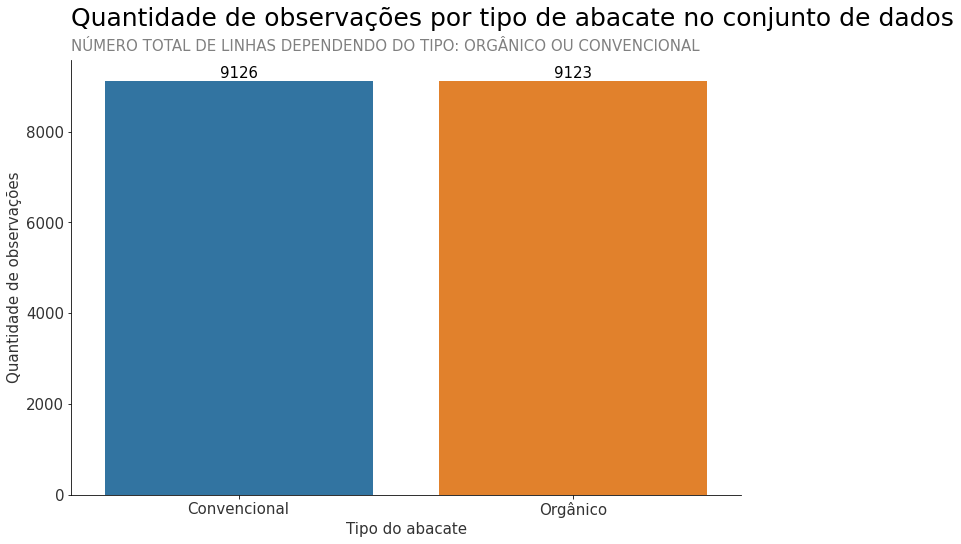

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(df['type'])
labs(ax, kwargs_grid={}, title='Quantidade de observações por tipo de abacate no conjunto de dados',
    subtitle='NÚMERO TOTAL DE LINHAS DEPENDENDO DO TIPO: ORGÂNICO OU CONVENCIONAL', xlabel='Tipo do abacate', ylabel='Quantidade de observações')
plt.xticks(range(2), ['Convencional', 'Orgânico'])
annot_bar(ax, prop=False)
plt.show()

In [19]:
df['region'].value_counts()

Albany                 338
Sacramento             338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland               338
RaleighGreensboro      338
RichmondNorfolk        338
Roanoke                338
SanDiego               338
Atlanta                338
SanFrancisco           338
Seattle                338
SouthCarolina          338
SouthCentral           338
Southeast              338
Spokane                338
StLouis                338
Syracuse               338
Tampa                  338
TotalUS                338
West                   338
NewYork                338
NewOrleansMobile       338
Nashville              338
Midsouth               338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago                338
C

## Análise temporal

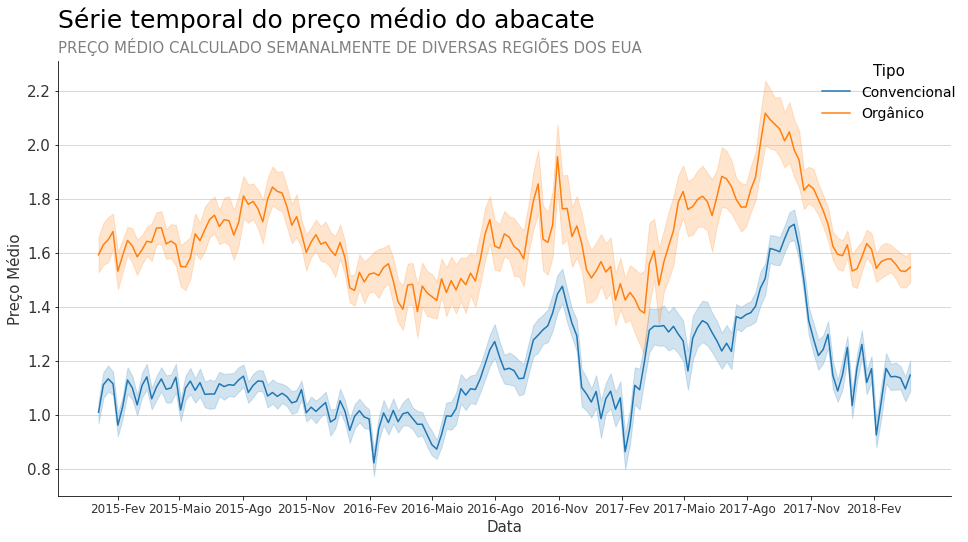

In [20]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='Date', y='AveragePrice', data=df, hue='type')
labs(ax, title='Série temporal do preço médio do abacate', subtitle='PREÇO MÉDIO CALCULADO SEMANALMENTE DE DIVERSAS REGIÕES DOS EUA',
    xlabel='Data', ylabel='Preço Médio')
plt.xticks(pd.date_range(min(df['Date']), max(df['Date']), freq='3MS'),
           pd.date_range(min(df['Date']), max(df['Date']), freq='3MS').strftime('%Y-%b').map(func_map_months), 
           color='#333333', fontsize=12)
plt.legend(labels = ['Convencional', 'Orgânico'], title='Tipo', fontsize=14, title_fontsize=15, frameon=False, loc=[.85,.85])
plt.show()

In [21]:
df_time = df.copy()
df_time['month'] = df_time['Date'].dt.month
df_time['day'] = df_time['Date'].dt.day
df_time['week_year'] = df_time['Date'].dt.week
df_time.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,day,week_year
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,27,52
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,20,51
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,13,50
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6,49
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,29,48


In [22]:
df_avg_by_month = df_time.groupby(['month', 'year', 'type']).agg({'AveragePrice':'mean'})
df_avg_by_week = df_time.groupby(['week_year', 'year', 'type']).agg({'AveragePrice':'mean'})

In [23]:
palette_conventional = ['#23B5DF', '#437AE1', '#1838EA', '#091E94']
palette_organic = ['#ECAC2D', '#D46010', '#E33A09', '#F90202']

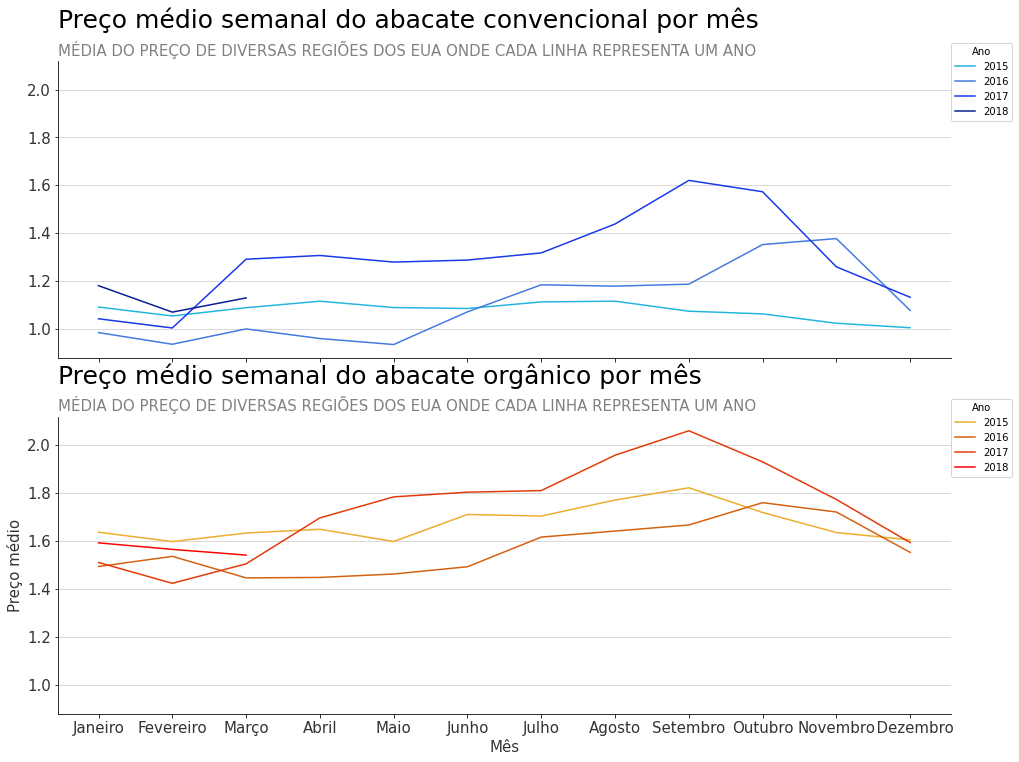

In [24]:
fig, ax = plt.subplots(2, 1,figsize=(16, 12), sharex=True, sharey=True)
sns.lineplot(x='month', y='AveragePrice', data=df_avg_by_month.query("type=='conventional'"), hue='year', ax=ax[0], palette=palette_conventional)
sns.lineplot(x='month', y='AveragePrice', data=df_avg_by_month.query("type=='organic'"), hue='year', ax=ax[1], palette=palette_organic)
plt.xticks(range(1,13), ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', '  Dezembro'])
labs(ax[0], title='Preço médio semanal do abacate convencional por mês', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO')
labs(ax[1], title='Preço médio semanal do abacate orgânico por mês', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO',
    xlabel='Mês', ylabel='Preço médio')
ax[0].legend(title='Ano', loc=[1,0.8])
ax[1].legend(title='Ano', loc=[1,0.8])
plt.show()

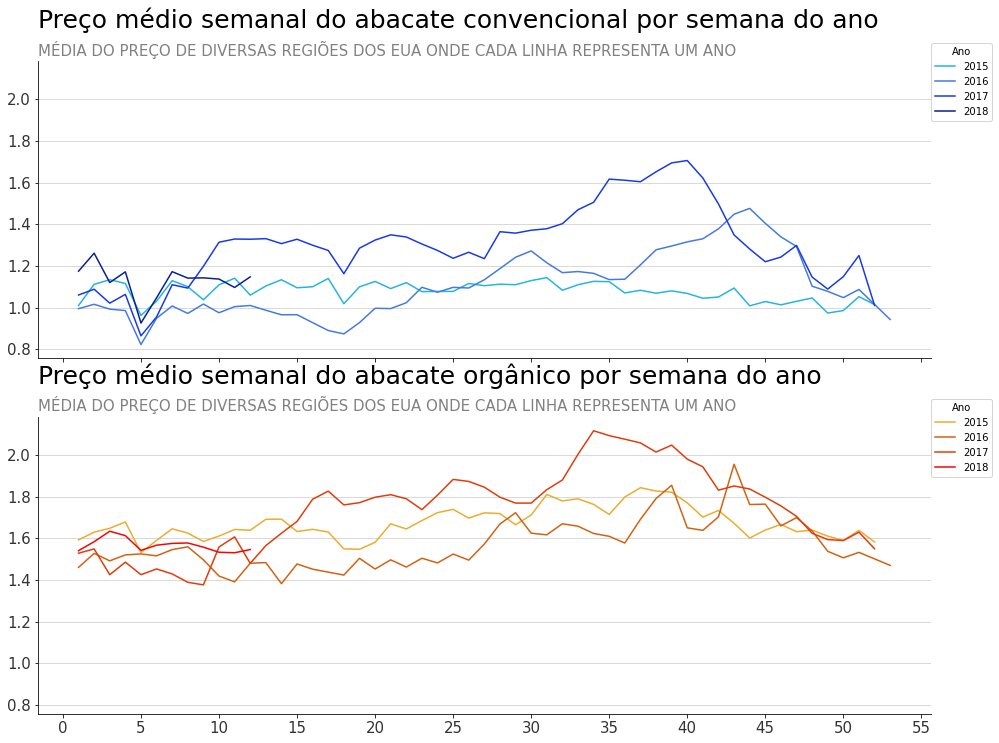

In [25]:
fig, ax = plt.subplots(2, 1,figsize=(16, 12), sharex=True, sharey=True)
sns.lineplot(x='week_year', y='AveragePrice', data=df_avg_by_week.query("type=='conventional'"), hue='year', ax=ax[0], palette=palette_conventional)
sns.lineplot(x='week_year', y='AveragePrice', data=df_avg_by_week.query("type=='organic'"), hue='year', ax=ax[1], palette=palette_organic)
plt.xticks(range(0,58,5))
labs(ax[0], title='Preço médio semanal do abacate convencional por semana do ano', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO')
labs(ax[1], title='Preço médio semanal do abacate orgânico por semana do ano', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO')
ax[0].legend(title='Ano', loc=[1,0.8])
ax[1].legend(title='Ano', loc=[1,0.8])
plt.show()

## Análise das variáveis numéricas

In [26]:
numeric_columns = df.select_dtypes('float64').columns.tolist()

In [27]:
df[numeric_columns].describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000


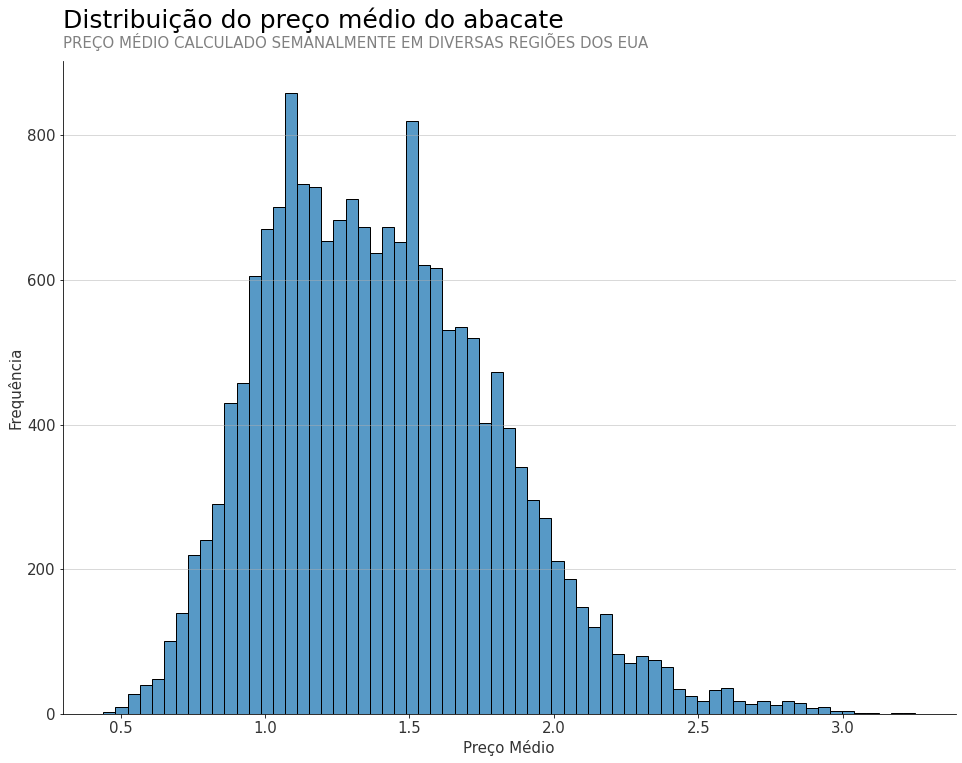

In [28]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.histplot(df['AveragePrice'])
labs(ax, title='Distribuição do preço médio do abacate',
    subtitle='PREÇO MÉDIO CALCULADO SEMANALMENTE EM DIVERSAS REGIÕES DOS EUA', xlabel='Preço Médio', ylabel='Frequência')
plt.show()

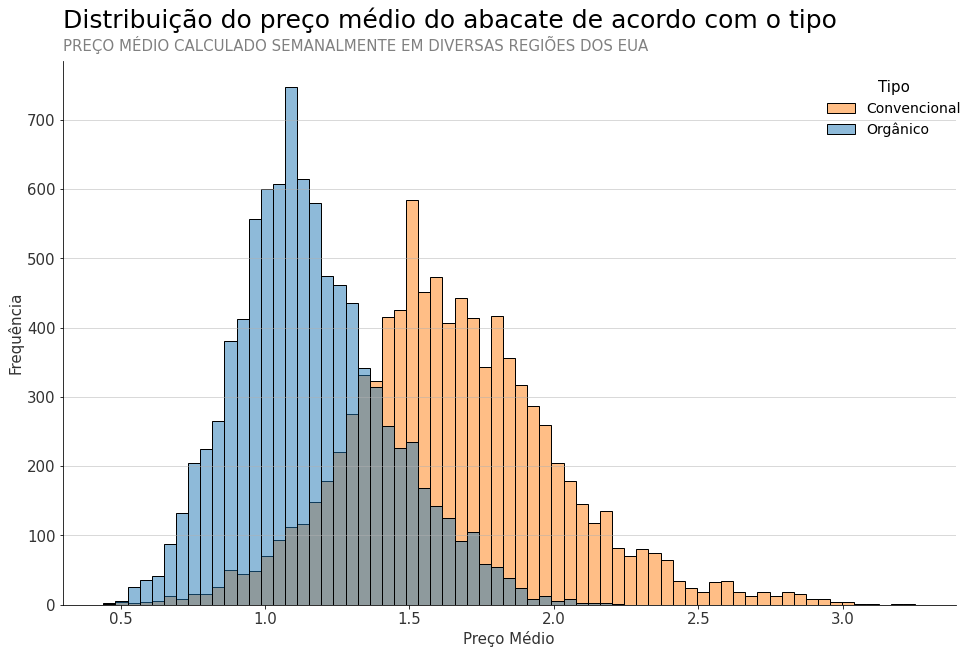

In [29]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(x='AveragePrice', hue='type', data=df)
labs(ax, title='Distribuição do preço médio do abacate de acordo com o tipo',
    subtitle='PREÇO MÉDIO CALCULADO SEMANALMENTE EM DIVERSAS REGIÕES DOS EUA', xlabel='Preço Médio', ylabel='Frequência')
plt.legend(labels = ['Convencional', 'Orgânico'], title='Tipo', fontsize=14, title_fontsize=15, frameon=False, loc=[.85,.85])
plt.show()

In [30]:
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


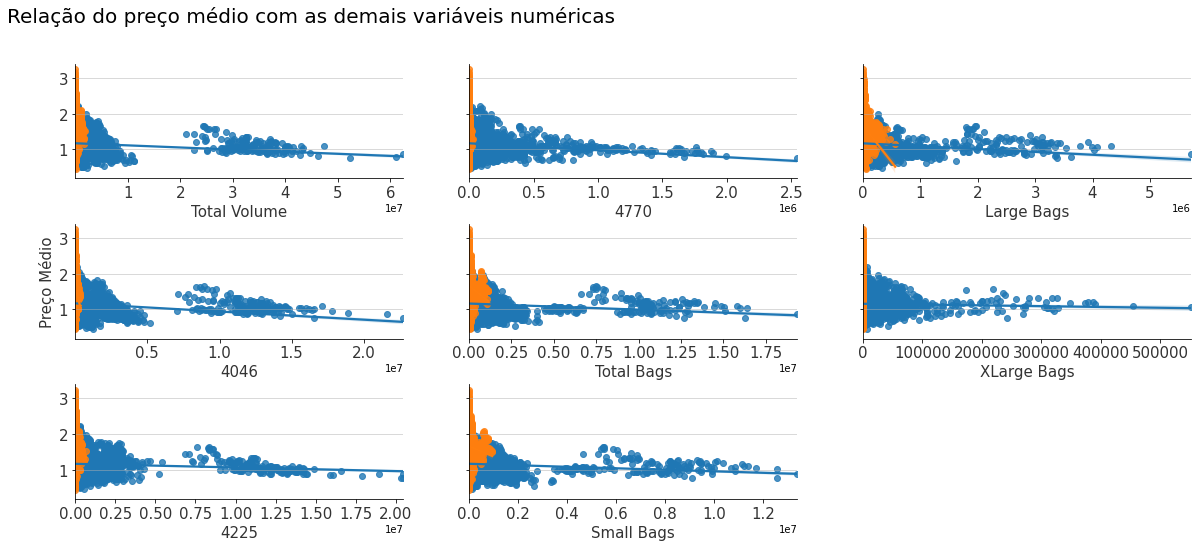

In [31]:
fig, ax = plt.subplots(3, 3, figsize=(20,8), sharey=True)
plt.subplots_adjust(hspace=.4)
for i, col in enumerate(df.drop('AveragePrice', axis=1).select_dtypes('float64').columns):
    if i < 3:
        j=0
    elif i < 6:
        j=1
        i=i-3
    else:
        j=2
        i=i-6
    hue_regplot(col, 'AveragePrice', hue='type', data=df, ax=ax[i,j])
    labs(ax[i,j], xlabel=col)
    
fig.suptitle('Relação do preço médio com as demais variáveis numéricas', fontsize=20, horizontalalignment='right')
ax[1,0].set_ylabel('Preço Médio')
plt.delaxes(ax[-1,-1])

In [32]:
cor = df[numeric_columns].corr()
cor_spearman = df[numeric_columns].corr(method='spearman')

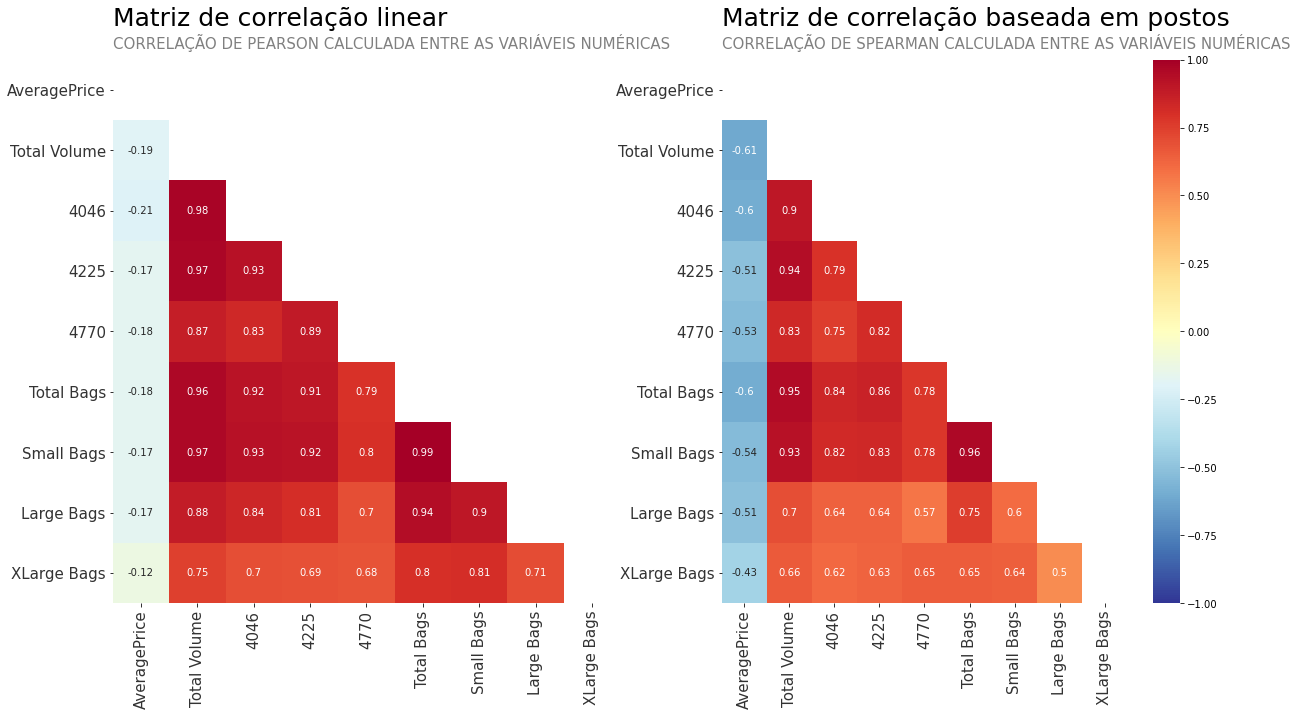

In [33]:
fig,ax = plt.subplots(1, 2,figsize=(20,10))
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, mask=mask, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=ax[0], cbar=False)
labs(ax[0], kwargs_grid={}, title='Matriz de correlação linear', subtitle='CORRELAÇÃO DE PEARSON CALCULADA ENTRE AS VARIÁVEIS NUMÉRICAS')
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))
sns.heatmap(cor_spearman, mask=mask, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=ax[1])
labs(ax[1], kwargs_grid={}, title='Matriz de correlação baseada em postos', subtitle='CORRELAÇÃO DE SPEARMAN CALCULADA ENTRE AS VARIÁVEIS NUMÉRICAS')
plt.show()

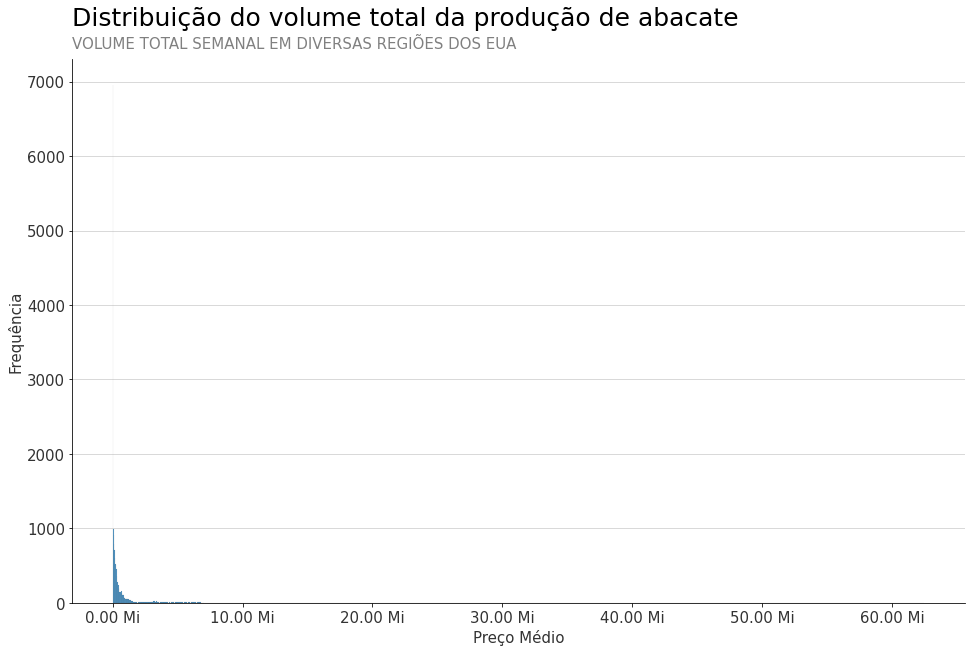

In [34]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(x='Total Volume', data=df)
labs(ax, title='Distribuição do volume total da produção de abacate',
    subtitle='VOLUME TOTAL SEMANAL EM DIVERSAS REGIÕES DOS EUA', xlabel='Preço Médio', ylabel='Frequência')
ax.xaxis.set_major_formatter(million_formatter)
plt.show()

In [35]:
z_total_volume = stats.zscore(df['Total Volume'], ddof=1) 
df_total_volume_outlier_neg = df[z_total_volume <= -3]
df_total_volume_outlier_pos = df[z_total_volume >= 3]

In [36]:
df_total_volume_outlier_neg

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region


In [37]:
df_total_volume_outlier_pos.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
2652,2015-12-27,0.95,27297983.67,9626901.09,10197890.05,1184340.09,6288852.44,4850404.09,1252626.31,185822.04,conventional,2015,TotalUS
2653,2015-12-20,0.98,25083647.17,8710021.76,9329861.85,1201020.01,5842743.55,4618389.66,1025048.77,199305.12,conventional,2015,TotalUS
2654,2015-12-13,0.93,28041335.38,9855053.66,10805838.91,1016163.17,6364279.64,4964462.13,1371440.28,28377.23,conventional,2015,TotalUS
2655,2015-12-06,0.89,28800396.57,9405464.36,12160838.62,931830.63,6302262.96,5005077.36,1233956.21,63229.39,conventional,2015,TotalUS
2656,2015-11-29,0.99,22617999.38,8094803.56,9003178.41,731008.41,4789009.00,3901953.04,856560.34,30495.62,conventional,2015,TotalUS


In [38]:
df_total_volume_outlier_pos['region'].unique()

array(['TotalUS', 'California', 'West'], dtype=object)

In [39]:
df_total_volume_outlier_pos['type'].unique()

array(['conventional'], dtype=object)

In [40]:
'''
fig, ax= plt.subplots(2, 1, figsize=(16,16))
plt.subplots_adjust(hspace=.3)

sns.barplot(y='region', x='Volume_total_mean', data = df_volume_total_mean_region_type.query('type=="conventional"').iloc[-10:,:], 
            color='blue', ax=ax[0], label = 'Convencional')
ax[0].barh(y='region', width='Volume_total_mean', data = df_volume_total_mean_region_type.query('type=="organic"').iloc[-10:,:], 
           color='red', left=[rect.get_width() for rect in ax[0].patches],  label = 'Orgânico')

ax[0].xaxis.set_major_formatter(million_formatter)
ax[0].invert_yaxis()
labs(ax[0], kwargs_grid={}, title='TOP 10 da média de volume total de abacate produzido por semana',
     subtitle='VOLUME CALCULADO POR CADA REGIÃO E TIPO DE ABACATE', xlabel='Volume Total')

sns.barplot(y='region', x='AveragePrice_mean', data = df_average_price_mean_region_type.query('type=="conventional"').iloc[-10:,:], 
            color='blue', ax=ax[1], label = 'Convencional')
ax[1].barh(y='region', width='AveragePrice_mean', data = df_average_price_mean_region_type.query('type=="organic"').iloc[-10:,:], 
           color='red', left=[rect.get_width() for rect in ax[1].patches],  label = 'Orgânico')

ax[1].invert_yaxis()
handles, labels = ax[1].get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, fontsize=15)
labs(ax[1], kwargs_grid={}, title='Preço médio de abacate nas 10 regiões mais produtoras de abacate', 
     subtitle='PREÇO CALCULADO POR CADA REGIÃO E TIPO DE ABACATE', xlabel='Preço Médio')
plt.show()'''

'\nfig, ax= plt.subplots(2, 1, figsize=(16,16))\nplt.subplots_adjust(hspace=.3)\n\nsns.barplot(y=\'region\', x=\'Volume_total_mean\', data = df_volume_total_mean_region_type.query(\'type=="conventional"\').iloc[-10:,:], \n            color=\'blue\', ax=ax[0], label = \'Convencional\')\nax[0].barh(y=\'region\', width=\'Volume_total_mean\', data = df_volume_total_mean_region_type.query(\'type=="organic"\').iloc[-10:,:], \n           color=\'red\', left=[rect.get_width() for rect in ax[0].patches],  label = \'Orgânico\')\n\nax[0].xaxis.set_major_formatter(million_formatter)\nax[0].invert_yaxis()\nlabs(ax[0], kwargs_grid={}, title=\'TOP 10 da média de volume total de abacate produzido por semana\',\n     subtitle=\'VOLUME CALCULADO POR CADA REGIÃO E TIPO DE ABACATE\', xlabel=\'Volume Total\')\n\nsns.barplot(y=\'region\', x=\'AveragePrice_mean\', data = df_average_price_mean_region_type.query(\'type=="conventional"\').iloc[-10:,:], \n            color=\'blue\', ax=ax[1], label = \'Convencio

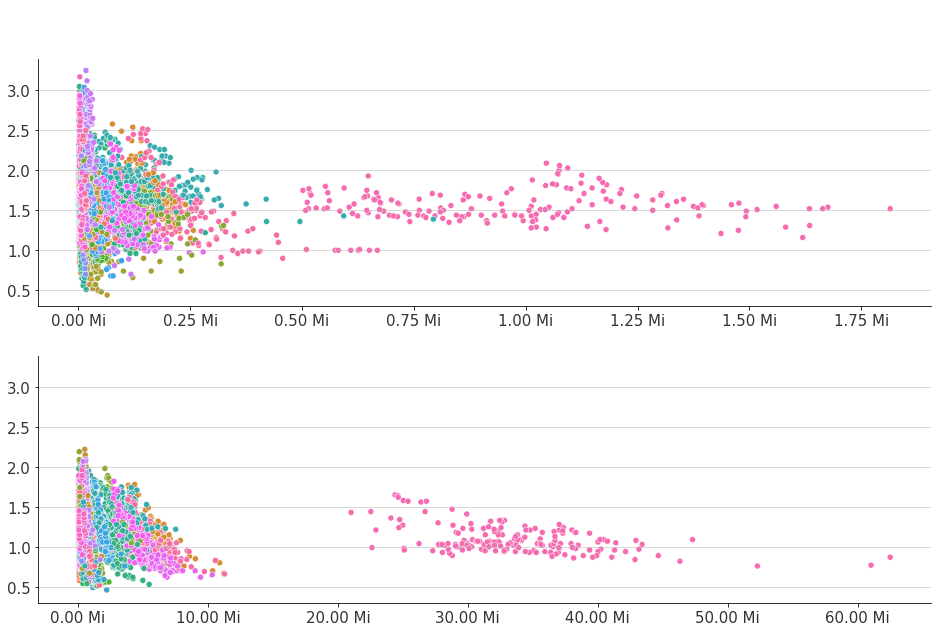

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10),  sharey=True)
sns.scatterplot(x='Total Volume', y='AveragePrice', data=df.query('type == "organic"'), hue='region', legend=False, ax=ax[0])
sns.scatterplot(x='Total Volume', y='AveragePrice', data=df.query('type == "conventional"'), hue='region', legend=False, ax=ax[1])
labs(ax[0])
labs(ax[1])
ax[0].xaxis.set_major_formatter(million_formatter)
ax[1].xaxis.set_major_formatter(million_formatter)
plt.show()

In [42]:
sg = ScalerGroup(groups=['type', 'region'])
df_scaled_group = sg.fit_transform(df.drop('AveragePrice', axis=1))
df_scaled_group.head()

,Date,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,-0.987456,-0.556151,-0.777528,-0.311312,-0.894325,-0.492950,-0.599732,-0.447487,conventional,2015,Albany
1,2015-12-20,-1.309863,-0.636439,-1.148503,-0.299903,-0.757986,-0.353050,-0.598583,-0.447487,conventional,2015,Albany
2,2015-12-13,0.872088,-0.609765,1.289537,-0.218941,-0.987307,-0.590583,-0.597052,-0.447487,conventional,2015,Albany
3,2015-12-06,-0.479180,-0.535050,-0.115341,-0.283917,-1.380834,-1.001841,-0.588755,-0.447487,conventional,2015,Albany
4,2015-11-29,-1.442047,-0.577252,-1.178753,-0.280327,-1.317984,-0.948128,-0.571431,-0.447487,conventional,2015,Albany


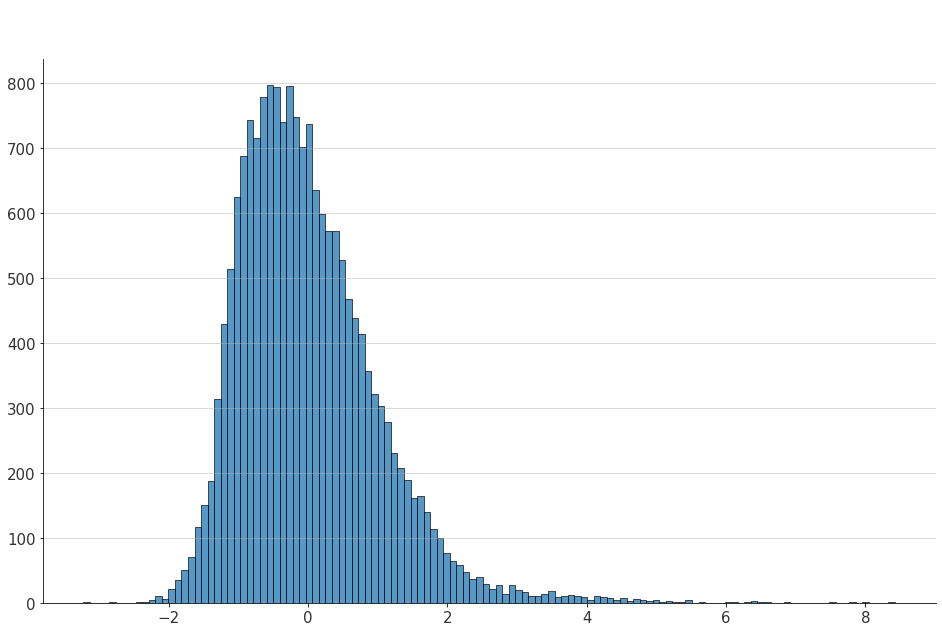

In [43]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(x='Total Volume', data=df_scaled_group)
labs(ax)
plt.show()

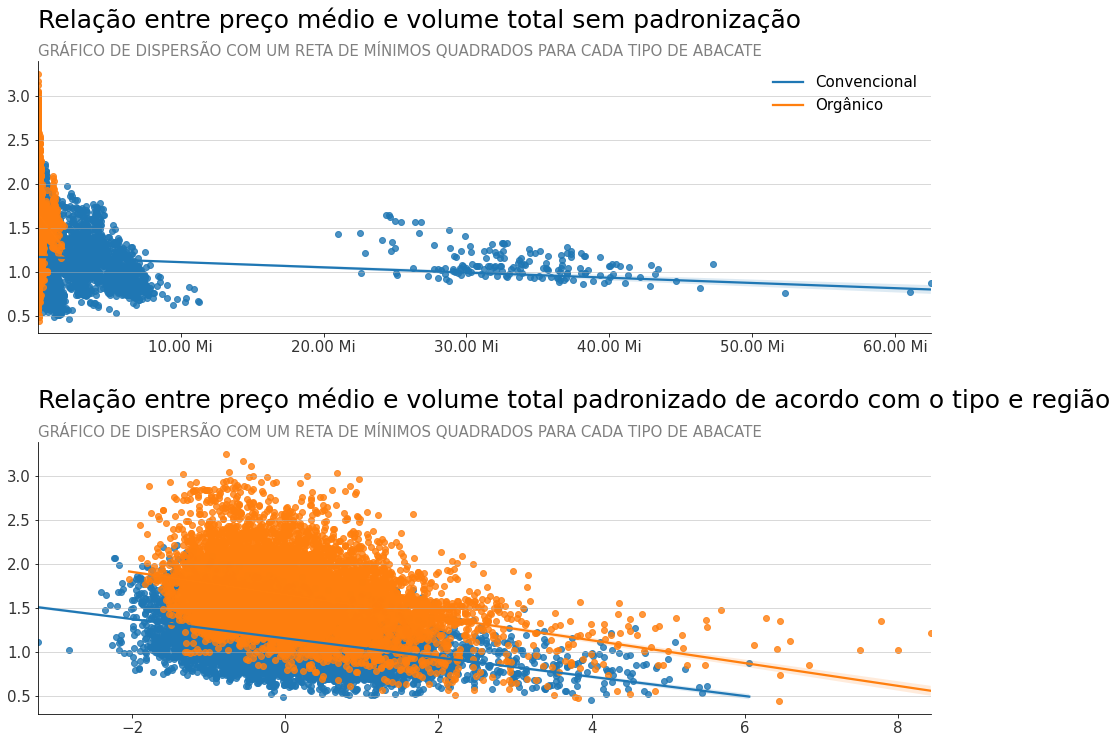

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=.4)
hue_regplot(x='Total Volume', y='AveragePrice', data=df, ax=ax[0], hue='type')
hue_regplot(x=df_scaled_group['Total Volume'], y=df['AveragePrice'], hue=df['type'], ax=ax[1])
labs(ax[0], title='Relação entre preço médio e volume total sem padronização', 
     subtitle='GRÁFICO DE DISPERSÃO COM UM RETA DE MÍNIMOS QUADRADOS PARA CADA TIPO DE ABACATE')
labs(ax[1], title='Relação entre preço médio e volume total padronizado de acordo com o tipo e região',
    subtitle='GRÁFICO DE DISPERSÃO COM UM RETA DE MÍNIMOS QUADRADOS PARA CADA TIPO DE ABACATE')
ax[0].legend(labels=['Convencional', 'Orgânico'], fontsize=15, frameon=False)
ax[0].xaxis.set_major_formatter(million_formatter)
plt.show()

In [47]:
# Armazenamento dos valores da coluna AveragePrice na variável y
y = df.sort_values('Date')['AveragePrice']
# Armazenamento dos valores das outras colunas restantes na variável X
X = df.sort_values('Date').drop(['AveragePrice'], axis = 1)

#
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

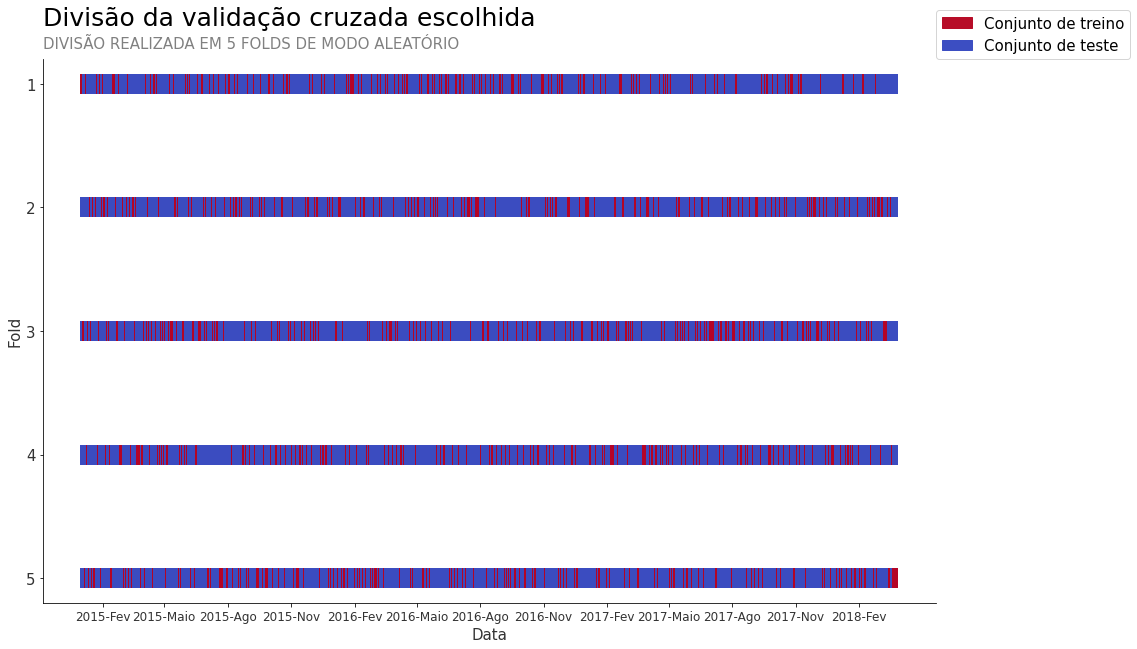

In [48]:
fig, ax = plt.subplots(figsize = (16, 10))
cmap_cv = plt.cm.coolwarm

for fold, (train, test) in enumerate(cv.split(X)):
    indices = np.zeros_like(X.index)
    indices[test] = 1
    
    ax.scatter(pd.date_range(min(X['Date']), max(X['Date']), periods=len(indices)), [fold + 1] * len(indices),
                   c=indices, marker='_', lw=20, cmap=cmap_cv)

ax.invert_yaxis()
labs(ax, kwargs_grid={}, ylabel='Fold', xlabel='Data', title='Divisão da validação cruzada escolhida', 
     subtitle='DIVISÃO REALIZADA EM 5 FOLDS DE MODO ALEATÓRIO')
plt.yticks(range(1, 6))
plt.xticks(pd.date_range(min(X['Date']), max(X['Date']), freq='3MS'),
           pd.date_range(min(X['Date']), max(X['Date']), freq='3MS').strftime('%Y-%b').map(func_map_months), 
           color='#333333', fontsize=12)
plt.legend([Patch(color=cmap_cv(.99)), Patch(color=cmap_cv(1))], ['Conjunto de treino', 'Conjunto de teste'],
          fontsize=15, loc=[1,1])
plt.show()

In [93]:
pipe_lr = Pipeline([('Scaler_cont', ScalerGroup()),    
                    ('transform_date', TransformDate()),
                    ('Norm_date', NormRank()),
                    ('Encoder',EncoderDummies()),
                    ('lr', XGBRegressor(random_state=SEED))]) 

In [94]:
# Armazenamento dos valores da coluna AveragePrice na variável y
y = df.sort_values('Date')['AveragePrice']
# Armazenamento dos valores das outras colunas restantes na variável X
X = df.sort_values('Date').drop('AveragePrice', axis = 1)

In [95]:
shap_values_list = []
x_test_shap_list = []
rmse_s = []
r2_scores = []
for fold, (train, test) in zip(tqdm(range(5)), cv.split(X, y)):
    
    pipe_lr.fit(X.iloc[train,:], y.iloc[train])
    shap_values, X_test_transformed = shap_tree_pipe(pipe_lr, X.iloc[test, :])
    shap_values_list.append(shap_values)
    x_test_shap_list.append(X_test_transformed)
    
    y_pred = pipe_lr[-1].predict(X_test_transformed)
    R2 = r2_score(y.iloc[test], y_pred)
    r2_scores.append(R2)
    RMSE = mean_squared_error(y.iloc[test], y_pred, squared=False)
    rmse_s.append(RMSE)
    print(f'Fold {fold + 1} : R2 = {R2} \n         RMSE = {RMSE}\n')
print(np.mean(r2_scores), np.mean(rmse_s))

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2 = 0.9076709794412577 
         RMSE = 0.12210787000722255

Fold 2 : R2 = 0.916306928957219 
         RMSE = 0.11571972124219594

Fold 3 : R2 = 0.9101276944264989 
         RMSE = 0.12039114365281492

Fold 4 : R2 = 0.915316334426607 
         RMSE = 0.1187535613908382

Fold 5 : R2 = 0.9083928797532429 
         RMSE = 0.12152072859365812

0.911562963400965 0.11969860497734594


In [82]:
from sklearn.feature_selection import RFE

In [103]:
pipe_lr = Pipeline([('Scaler_cont', ScalerGroup()),    
                    ('transform_date', TransformDate()),
                    ('Norm_date', NormRank()),
                    ('Encoder',EncoderDummies()),
                    ('feature_selection', RFECV(XGBRegressor(random_state=SEED), cv=cv, scoring='neg_root_mean_squared_error')),
                    ('lr', XGBRegressor(random_state=SEED))]) 

In [104]:
rmse_s = []
r2_scores = []
for fold, (train, test) in zip(tqdm(range(5)), cv.split(X, y)):
    
    pipe_lr.fit(X.iloc[train,:], y.iloc[train])
    y_pred = pipe_lr.predict(X.iloc[test, :])
    R2 = r2_score(y.iloc[test], y_pred)
    r2_scores.append(R2)
    RMSE = mean_squared_error(y.iloc[test], y_pred, squared=False)
    rmse_s.append(RMSE)
    print(f'Fold {fold + 1} : R2 = {R2} \n         RMSE = {RMSE}\n')
print(np.mean(r2_scores), np.mean(rmse_s))

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2 = 0.9089759428490188 
         RMSE = 0.12124187273260546

Fold 2 : R2 = 0.9166837405012247 
         RMSE = 0.11545892475520257

Fold 3 : R2 = 0.9109839633773296 
         RMSE = 0.1198162506521844

Fold 4 : R2 = 0.9155331157224992 
         RMSE = 0.11860146566450178

Fold 5 : R2 = 0.9083928797532429 
         RMSE = 0.12152072859365812

0.912113928440663 0.11932784847963047


In [63]:
shap_values = np.concatenate(shap_values_list)
x_test_shap = pd.concat(x_test_shap_list, axis=0)

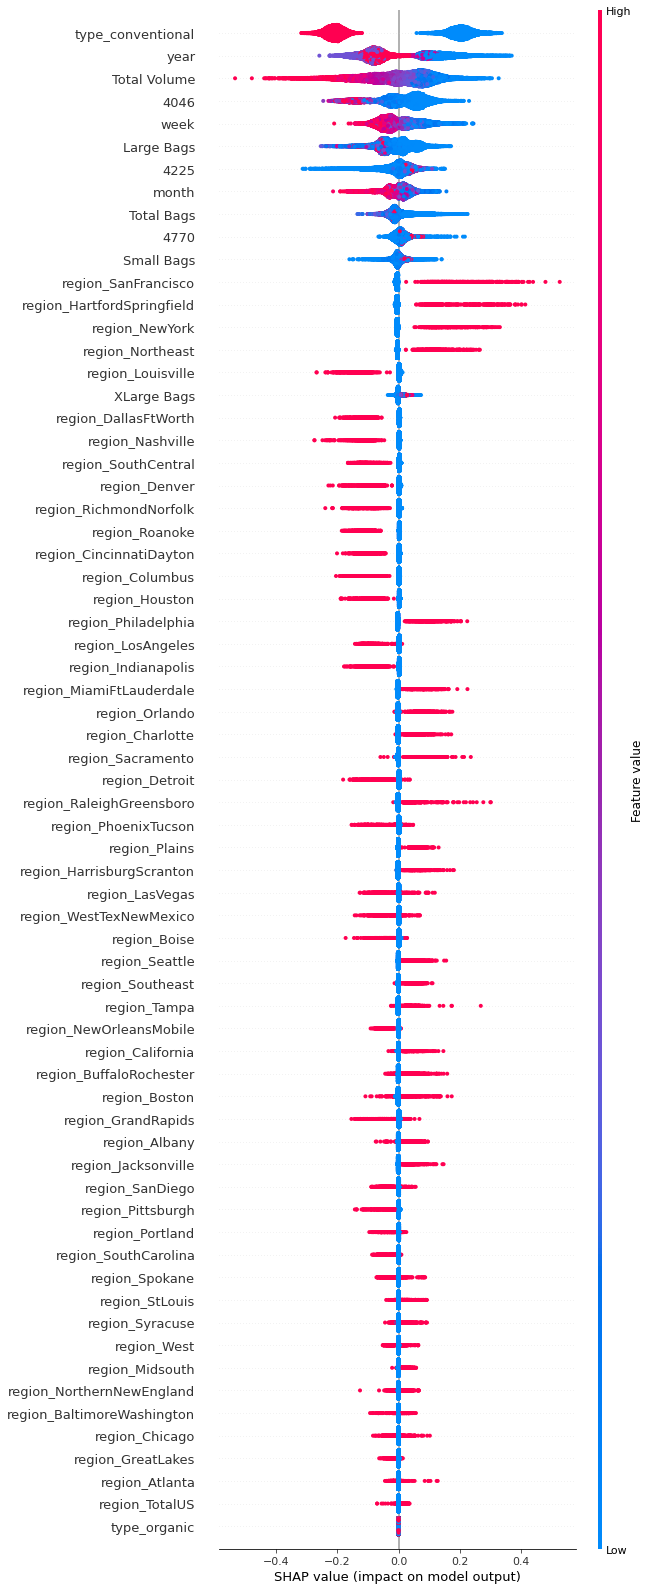

In [64]:
shap.summary_plot(shap_values, x_test_shap, max_display=67)